<a href="https://colab.research.google.com/github/goshan16389/ii_ubiet_mir/blob/main/7task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Подключение Google Drive для доступа к датасету
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -lh "/content/drive/MyDrive/Colab Notebooks/"

total 1.7G
-rw------- 1 root root 237K Mar 25  2025 '4.1"'
-rw------- 1 root root 108K Mar 25  2025 '4.2"'
-rw------- 1 root root  65K Mar 25  2025 '4.3"'
-rw------- 1 root root  74K Mar 25  2025 '5.1"'
-rw------- 1 root root 148K Mar 25  2025 '5.2"'
-rw------- 1 root root  47K Mar 25  2025 '5.3"'
-rw------- 1 root root 1.2M Jan 14 17:00  5task.ipynb
-rw------- 1 root root 420K May  7  2025  AgentOriented.ipynb
drwx------ 2 root root 4.0K Mar 25  2025  Gen
-rw------- 1 root root 3.6M Apr 16  2025  Gen4.jpg
-rw------- 1 root root 851K Apr 30  2025  GenProg.ipynb
-rw------- 1 root root 194K Mar 12  2025  Lab2.ipynb
-rw------- 1 root root 1.6K Nov  5 13:45  Models_lab9.ipynb
-rw------- 1 root root 1.7G Jan 15 09:36  plant-seedlings-classification.zip
-rw------- 1 root root 166K Mar 12  2025  T06_lec.ipynb
-rw------- 1 root root  19K Mar 12  2025  T06_w11_w12.ipynb
-rw------- 1 root root 135K Feb 26  2025  T_07_2_Groupping.ipynb
-rw------- 1 root root 101K Mar 12  2025  T07_lec.ipynb
-rw--

In [ ]:
# Распаковка архива с изображениями
!unzip -q "/content/drive/MyDrive/Colab Notebooks/plant-seedlings-classification.zip"
# https://www.kaggle.com/competitions/plant-seedlings-classification/data

In [ ]:
!ls /content/train | head -n 15

drive  sample_data  sample_submission.csv  test  train
Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet


In [ ]:
# Импорт основных библиотек PyTorch и вспомогательных инструментов
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Выбор устройства выполнения (GPU при наличии)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Фиксация seed для воспроизводимости экспериментов
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Определение аугментаций для обучающей выборки
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Определение преобразований для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Загрузка датасета изображений из папочной структуры
data_dir = 'train'

full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

In [ ]:
# Разбиение датасета на обучающую и валидационную выборки
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

In [ ]:
val_ds.dataset.transform = val_transform

# Создание DataLoader'ов
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Получение списка классов
class_names = full_dataset.classes
print(f"Классов: {len(class_names)} → {class_names}")

Классов: 12 → ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
# Загрузка предобученной модели ResNet50
model = models.resnet50(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Задание взвешенной функции потерь для борьбы с дисбалансом классов
class_weights = torch.tensor([1.0 if c != 0 else 3.0 for c in range(12)]).to(device)  # сильно поднять вес Black-grass
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Настройка оптимизатора с разными learning rate для слоёв
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': [p for n, p in model.named_parameters() if "layer4" in n], 'lr': 1e-5}
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Инициализация параметров обучения и early stopping
num_epochs = 15

best_val_loss = float('inf')
best_epoch = 0
patience = 5
counter = 0

best_model_path = 'best_plant_model.pth'

# Планировщик learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=3,
    min_lr=1e-7
)


# Основной цикл обучения модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader,
                     desc=f"Epoch {epoch+1}/{num_epochs} [train]",
                     leave=False)

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_loss = running_loss / total_train
        current_acc = 100 * correct_train / total_train
        train_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.1f}%")

    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    # Валидация модели
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            preds_all.extend(predicted.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    val_loss = val_running_loss / total
    val_acc = 100 * correct / total

    print(f"[{epoch+1:2d}/{num_epochs}]  "
          f"train loss: {train_loss:.4f} ({train_acc:.1f}%)  |  "
          f"val loss:   {val_loss:.4f} ({val_acc:.2f}%)")

    scheduler.step(val_loss)

    # Early stopping и сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  → Модель стала лучше, val_loss = {val_loss:.4f} (эпоха {best_epoch})")
    else:
        counter += 1
        print(f"  → Нет улучшений, № раз = {counter}/{patience}")

    if counter >= patience:
        print(f"Обучение остановлено после {epoch+1} эпох!")
        break

print("\n" + "="*60)
print(f"Обучение завершено. Лучшая модель: эпоха {best_epoch}, "
      f"val_loss = {best_val_loss:.4f}")

Epoch 1/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 1/15]  train loss: 1.3408 (56.5%)  |  val loss:   0.6135 (80.53%)
  → Модель стала лучше, val_loss = 0.6135 (эпоха 1)


Epoch 2/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 2/15]  train loss: 0.4843 (84.4%)  |  val loss:   0.4129 (84.21%)
  → Модель стала лучше, val_loss = 0.4129 (эпоха 2)


Epoch 3/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 3/15]  train loss: 0.2774 (91.5%)  |  val loss:   0.2891 (90.53%)
  → Модель стала лучше, val_loss = 0.2891 (эпоха 3)


Epoch 4/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 4/15]  train loss: 0.1596 (95.7%)  |  val loss:   0.2737 (91.47%)
  → Модель стала лучше, val_loss = 0.2737 (эпоха 4)


Epoch 5/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 5/15]  train loss: 0.0929 (97.6%)  |  val loss:   0.3145 (92.95%)
  → Нет улучшений, № раз = 1/5


Epoch 6/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 6/15]  train loss: 0.0530 (98.9%)  |  val loss:   0.2722 (91.68%)
  → Модель стала лучше, val_loss = 0.2722 (эпоха 6)


Epoch 7/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 7/15]  train loss: 0.0474 (98.9%)  |  val loss:   0.2947 (93.37%)
  → Нет улучшений, № раз = 1/5


Epoch 8/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 8/15]  train loss: 0.0224 (99.7%)  |  val loss:   0.3371 (92.84%)
  → Нет улучшений, № раз = 2/5


Epoch 9/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[ 9/15]  train loss: 0.0165 (99.8%)  |  val loss:   0.3443 (93.26%)
  → Нет улучшений, № раз = 3/5


Epoch 10/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[10/15]  train loss: 0.0124 (99.8%)  |  val loss:   0.3752 (93.58%)
  → Нет улучшений, № раз = 4/5


Epoch 11/15 [train]:   0%|          | 0/119 [00:00<?, ?it/s]

[11/15]  train loss: 0.0101 (99.9%)  |  val loss:   0.3497 (93.58%)
  → Нет улучшений, № раз = 5/5
Обучение остановлено после 11 эпох!

Обучение завершено. Лучшая модель: эпоха 6, val_loss = 0.2722


In [ ]:
best_model_path = 'best_plant_model.pth'

In [ ]:
# Загрузка лучшей сохранённой модели
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

In [ ]:
# Получение предсказаний на валидационной выборке
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
class_names = full_dataset.classes
print(f"Количество классов: {len(class_names)}")
print("Классы:", class_names)

Количество классов: 12
Классы: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
# Формирование отчёта по классификации
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3
)
print(report)

with open('model_report.txt', 'w') as f:
    f.write(f"Точность на тестовой выборке: {test_acc:.4f}\n\n")
    f.write(report)


Classification Report на лучшей модели (валидация):
                           precision    recall  f1-score   support

              Black-grass      0.513     0.765     0.614        51
                 Charlock      0.973     1.000     0.986        71
                 Cleavers      0.967     0.935     0.951        62
         Common Chickweed      0.946     0.972     0.959       109
             Common wheat      0.960     0.873     0.914        55
                  Fat Hen      0.980     0.960     0.970       100
         Loose Silky-bent      0.898     0.774     0.831       137
                    Maize      0.976     1.000     0.988        41
        Scentless Mayweed      0.907     0.942     0.925       104
          Shepherds Purse      0.911     0.854     0.882        48
Small-flowered Cranesbill      0.990     0.981     0.986       105
               Sugar beet      1.000     0.955     0.977        67

                 accuracy                          0.917       950
       

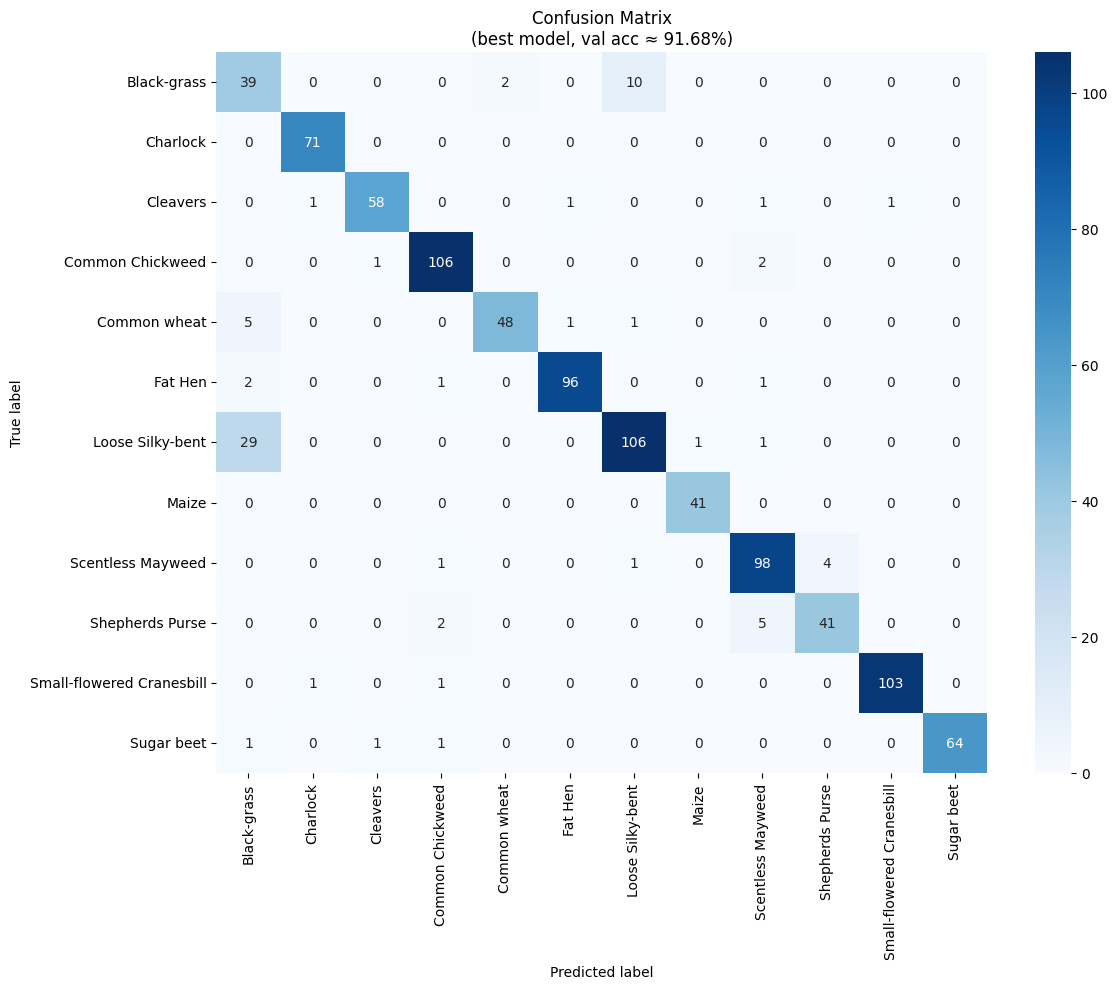

In [ ]:
# Построение confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
from google.colab import files

files.download('best_plant_model.pth')
files.download('model_report.txt')
files.download('confusion_matrix.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>